In [ ]:
def grab_training_data(volume_id, upside_down=True):
    
    import boto3
    
    s3_resource = boto3.resource("s3")
    s3_client = boto3.client("s3")
    
    source_bucket = s3_resource.Bucket("ssda-production-jpgs")
    images = 0
    
    for obj in source_bucket.objects.filter(Prefix = volume_id):
        if upside_down:
            s3_client.download_file("ssda-production-jpgs", obj.key, "E:\\folio_samples\\upside_down\\" + obj.key)
            images += 1
        else:
            s3_client.download_file("ssda-production-jpgs", obj.key, "E:\\folio_samples\\right_side_up\\" + obj.key)
            images += 1
            
    return str(images) + " images from " + volume_id + " downloaded to " + int(upside_down) * "upside down training data." + int(not upside_down) * "right side up training data."

In [ ]:
grab_training_data("704112", upside_down=True)

'6 images from 704112 downloaded to upside down training data.'

In [ ]:
#developed based on https://www.tensorflow.org/tutorials/images/classification

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

data_dir = "E:\\folio_samples"

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2342 files belonging to 2 classes.
Using 1874 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2342 files belonging to 2 classes.
Using 468 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['right_side_up', 'upside_down']


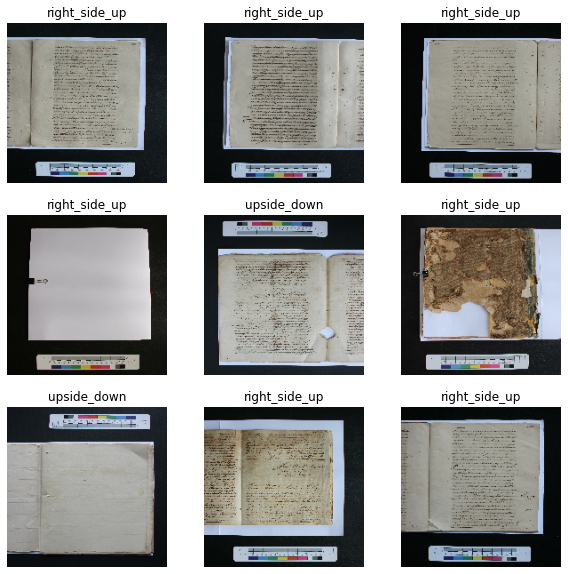

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9279222


In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
59/59 [==============================] - 11s 176ms/step - loss: 0.1078 - accuracy: 0.9578 - val_loss: 4.5997e-06 - val_accuracy: 1.0000
Epoch 2/10
59/59 [==============================] - 9s 150ms/step - loss: 0.0173 - accuracy: 0.9989 - val_loss: 1.7196e-04 - val_accuracy: 1.0000
Epoch 3/10
59/59 [==============================] - 9s 149ms/step - loss: 0.0099 - accuracy: 0.9989 - val_loss: 4.2967e-04 - val_accuracy: 1.0000
Epoch 4/10
59/59 [==============================] - 9s 149ms/step - loss: 0.0074 - accuracy: 0.9989 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 5/10
59/59 [==============================] - 9s 149ms/step - loss: 0.0078 - accuracy: 0.9989 - val_loss: 0.0035 - val_accuracy: 1.0000
Epoch 6/10
59/59 [==============================] - 9s 148ms/step - loss: 0.0062 - accuracy: 0.9989 - val_loss: 6.9079e-04 - val_accuracy: 1.0000
Epoch 7/10
59/59 [==============================] - 9s 149ms/step - loss: 0.0043 - accuracy: 0.9989 - val_loss: 5.8151e-05 - val_ac

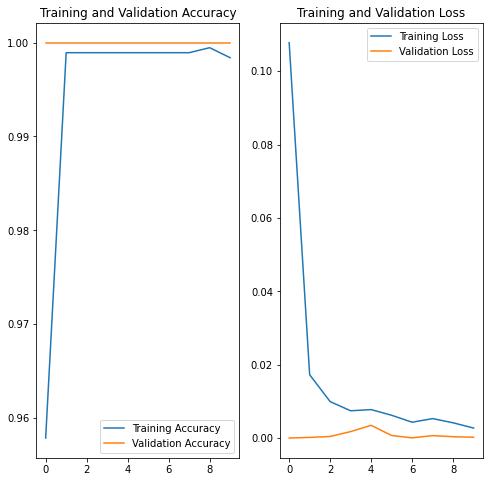

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
test_folder = "E:\\test_images\\"
file_name = "704107-0010.jpg"

img = tf.keras.utils.load_img(
    test_folder + file_name, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to right_side_up with a 99.84 percent confidence.
